In [1]:
%matplotlib notebook
import os,sys

!{sys.executable} -m pip install OpenVisus
!{sys.executable} -m pip install itk-io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ipywidgets import *
from urllib.request import urlretrieve
import OpenVisus as ov
import itk

from urllib.request import urlretrieve
import os

from itkwidgets import view

from ipywidgets import interactive
import ipywidgets as widgets
import time
from collections import defaultdict

ov.DbModule.attach()

PythonEngine is working fine


# Help functions provided by TA

In [2]:
def readData(dataset,time=None,field=None,logic_box=ov.BoxNi(),resolution=None):
    if(time==None):
        time=dataset.getDefaultTime()
    if(field==None):
        field=dataset.getDefaultField()
    if(logic_box==ov.BoxNi()):
        logic_box=dataset.getLogicBox()
    if(resolution==None):
        resolution=dataset.getMaxResolution()
    
    access=dataset.createAccess()
    query=ov.BoxQuery(dataset, field, time,ord('r'))
    query.logic_box=logic_box
    query.end_resolutions.push_back(resolution)
    dataset.beginQuery(query)
    dataset.executeQuery(access,query)
    data=ov.Array.toNumPy(query.buffer,bSqueeze=True,bShareMem=False)
    return data

def showData(data, cmap=None, plot=None):
    if(plot==None or cmap!=None):
        fig=plt.figure(figsize = (7,5))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot

# Call DataSet by openvisus

In [3]:
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=borg")

In [4]:
print("Maximum resolution of data is {}".format(dataset.getMaxResolution()))

Maximum resolution of data is 33


In [5]:
dataset.getTimesteps().toString()

'<DatasetTimesteps>\n\t<timestep from="0" to="15" step="1" />\n</DatasetTimesteps>'

# Problem1

In [6]:
#Save data file as raw file
data = readData(dataset, time=15, resolution=24)
y,x,z = data.shape
data.tofile("Problem1_result.raw")

In [7]:
#Call data file by view function
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

# Problem2

In [8]:
def helpfunc(t,res):
    data = readData(dataset, time=t, resolution=res)
    viewer.image = data
    
dt = readData(dataset, time=7, resolution=24)
viewer = view(dt)
slider = interactive(helpfunc, t = [x for x in range(16)], res = [x for x in range(15,26,3)])
widgets.VBox([viewer, slider])

# Problem3

In [9]:
t0 = time.process_time_ns()
class PercentMixedLayerForVolume:
    def __init__(self,res):
        self.res = res
    
    def PercentM(self,t):
        data = readData(dataset, time=t, resolution=self.res)
        x,y,z = data.shape
        total = 0
        for i in range(z):
            z_slice = data[:,:,i]
            x,y = z_slice.shape
            cnt = 0
            for j in range(x):
                check = 0
                row = list(z_slice[j])
                check+= row.count(0)+row.count(255)
                if y!=check:
                    cnt+=1
            total+=cnt
        avg = total/z
        return avg/x

dataV = defaultdict(list)
for res in [15,18,21,24]:
    p = PercentMixedLayerForVolume(res)
    for t in [x for x in range(16)]:
        dataV[res].append(p.PercentM(t))
t1 = time.process_time_ns() 

<IPython.core.display.Javascript object>


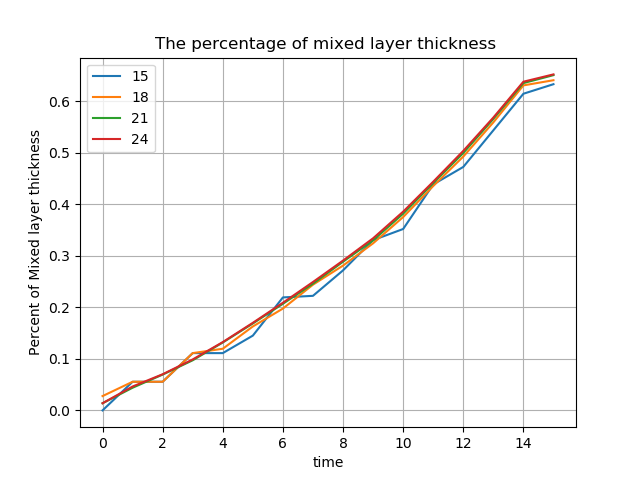

In [10]:
plt.figure()
for res in dataV:
    plt.plot([x for x in range(16)],dataV[res])

plt.title('The percentage of mixed layer thickness ')
plt.xlabel('time')
plt.ylabel('Percent of Mixed layer thickness')
plt.grid()
plt.legend(['15','18','21','24'])

In [11]:
print("Computing time is {} sec".format(t1-t0))

Computing time is 182468750000 sec


# Problem4

In [12]:
ts0 = time.process_time_ns()
class PercentMixedLayerForMiddle:
    def __init__(self,res):
        self.res = res
    
    def PercentX(self,t):
        data = readData(dataset, time=t, resolution=self.res)
        x,y,z = data.shape
        sliceX = data[x//2,:,:]
        x,y = sliceX.shape
        cnt = 0
        for j in range(x):
            check = 0
            row = list(sliceX[j])
            check+= row.count(0)+row.count(255)
            if y!=check:
                cnt+=1
        return cnt/x
    
    def PercentY(self,t):
        data = readData(dataset, time=t, resolution=self.res)
        x,y,z = data.shape
        sliceY = data[:,y//2,:]
        x,y = sliceY.shape
        cnt = 0
        for j in range(y):
            check = 0
            row = list(sliceY[j])
            check+= row.count(0)+row.count(255)
            if y!=check:
                cnt+=1
        return cnt/x
    
dataY,dataX = defaultdict(list),defaultdict(list)
for res in [15,18,21,24]:
    p = PercentMixedLayerForMiddle(res)
    for t in [x for x in range(16)]:
        dataY[res].append(p.PercentY(t))
        dataX[res].append(p.PercentX(t))
ts1 = time.process_time_ns()

<IPython.core.display.Javascript object>


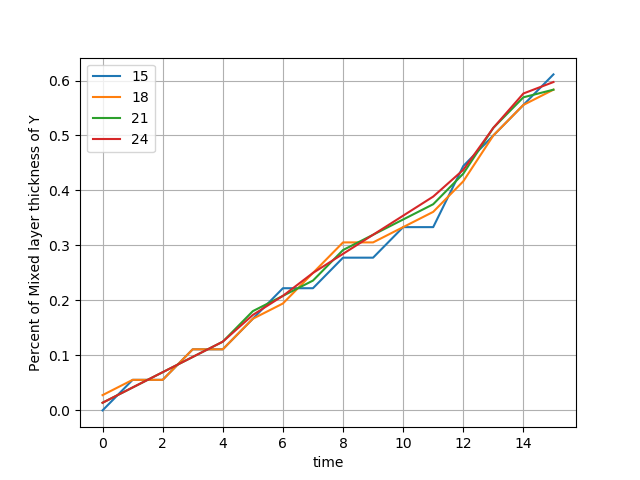

In [13]:
plt.figure()
for res in dataY:
    plt.plot([x for x in range(16)],dataY[res])
    
plt.xlabel('time')
plt.ylabel('Percent of Mixed layer thickness of Y')
plt.grid()
plt.legend(['15','18','21','24'])

In [14]:
#Image of Y
x,y,z = data.shape
sliceY = data[:,y//2,:]
view(sliceY)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC2; proxy …

<IPython.core.display.Javascript object>


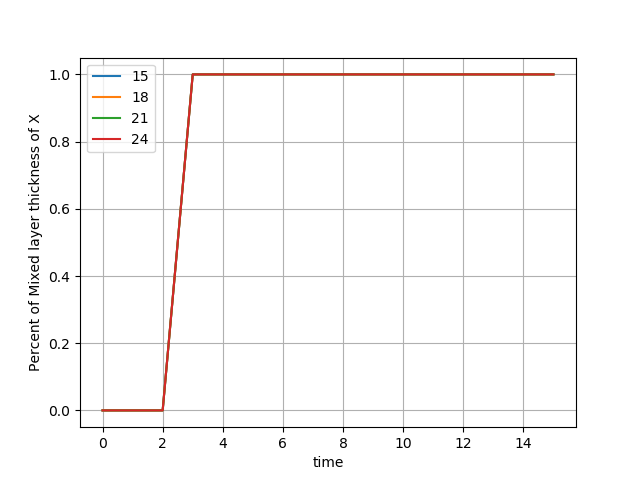

In [15]:
plt.figure()
for res in dataX:
    plt.plot([x for x in range(16)],dataX[res])
    
plt.xlabel('time')
plt.ylabel('Percent of Mixed layer thickness of X')
plt.grid()
plt.legend(['15','18','21','24'])

In [16]:
#Image of X
x,y,z = data.shape
sliceX = data[x//2,:,:]
view(sliceX)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC2; proxy …

In [17]:
print("Computing time is {} sec".format(ts1-ts0))

Computing time is 36093750000 sec


# Problem5

In [18]:
#Define Resolution
res = 24

#Code3
tz0 = time.process_time_ns()
Z24 = []
pZ = PercentMixedLayerForVolume(res)
for t in [x for x in range(16)]:
    Z24.append(pZ.PercentM(t))
tz1 = time.process_time_ns()

#Call class of Code4
p = PercentMixedLayerForMiddle(res)
#Code4-X
tx0 = time.process_time_ns()
X24 = []
for t in [x for x in range(16)]:
    X24.append(p.PercentX(t))
tx1 = time.process_time_ns()

#Code4-Y
Y24 = []
ty0 = time.process_time_ns()
for t in [x for x in range(16)]:
    Y24.append(p.PercentY(t))
ty1 = time.process_time_ns()

<IPython.core.display.Javascript object>


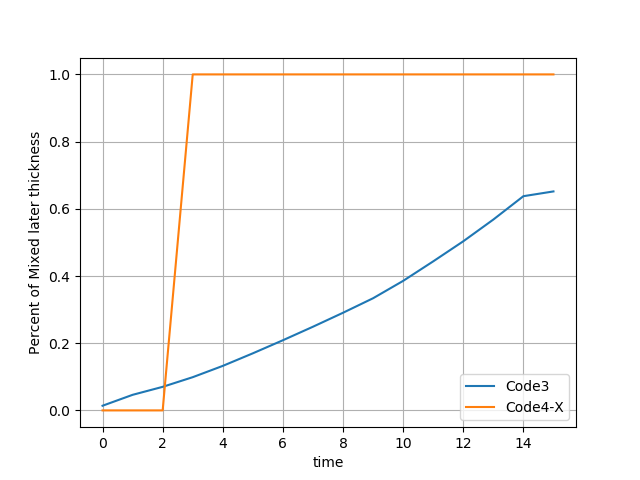

In [19]:
plt.figure()
plt.plot([x for x in range(16)],Z24)
plt.plot([x for x in range(16)],X24)
plt.xlabel('time')
plt.ylabel('Percent of Mixed later thickness')
plt.grid()
plt.legend(['Code3','Code4-X'])

<IPython.core.display.Javascript object>


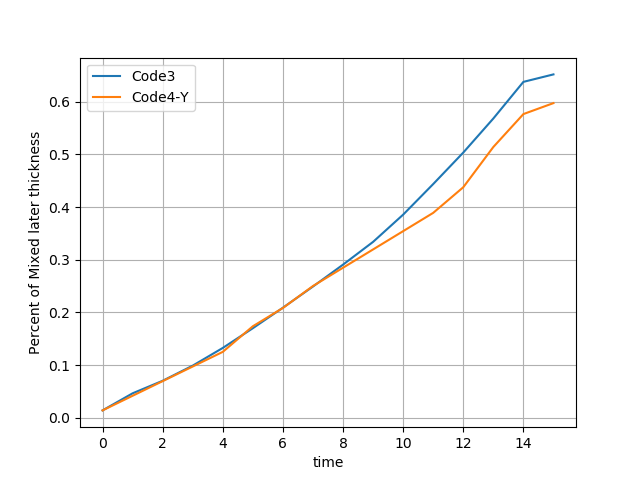

In [20]:
plt.figure()
plt.plot([x for x in range(16)],Z24)
plt.plot([x for x in range(16)],Y24)
plt.xlabel('time')
plt.ylabel('Percent of Mixed later thickness')
plt.grid()
plt.legend(['Code3','Code4-Y'])

In [21]:
print("Computing time for code3 is {} sec".format(tz1-tz0))
print("Computing time for code4-X is {} sec".format(tx1-tx0))
print("Computing time for code4-Y is {} sec".format(ty1-ty0))

Computing time for code3 is 158234375000 sec
Computing time for code4-X is 15578125000 sec
Computing time for code4-Y is 15375000000 sec


# Problem7-linspace

In [23]:
#To find equally seperated array
for i in range(256):
    arr = np.linspace(i,255,20)
    if int(arr[1])==arr[1]:
        break
print("Array is {0} and its length is {1}".format(arr,len(arr)))

Array is [  8.  21.  34.  47.  60.  73.  86.  99. 112. 125. 138. 151. 164. 177.
 190. 203. 216. 229. 242. 255.] and its length is 20


# Problem8

In [24]:
class FindMixedLayer:
    def __init__(self,res):
        self.res = res
    
    def combineY(self):
        data = readData(dataset, time=0, resolution=self.res)
        y,x,z = data.shape
        self.total = np.zeros((y,x,z))
        cnt = 0 
        for t in [x for x in range(16)]:
            curData = readData(dataset, time=t, resolution=self.res)
            if t!=15:
                self.total[:,cnt:cnt+y//16,:] = curData[:,cnt:cnt+y//16,:]
            else:
                self.total[:,cnt:,:] = curData[:,cnt:,:]
            cnt+=y//16
        
        self.total = np.array(self.total,dtype=np.uint8)
        
    def combineX(self):
        data = readData(dataset, time=0, resolution=self.res)
        y,x,z = data.shape
        self.totalX = np.zeros((y,x,z))
        cnt = 0 
        for t in [x for x in range(16)]:
            curData = readData(dataset, time=t, resolution=self.res)
            if t!=15:
                self.totalX[cnt:cnt+y//16,:,:] = curData[cnt:cnt+y//16,:,:]
            else:
                self.totalX[cnt:,:,:] = curData[cnt:,:,:]
            cnt+=y//16
        
        self.totalX = np.array(self.total,dtype=np.uint8)
        
        
f = FindMixedLayer(24)
f.combineY()
f.combineX()

In [25]:
f.total.tofile("problem6.raw")

In [26]:
view(f.total)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [27]:
view(f.totalX)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …